In [1]:
import datetime as dt

import pandas as pd
import numpy as np
import statsmodels.api as sm
import pyfolio as pf
import matplotlib.pyplot as plt
import seaborn as sns
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier

# silence warnings
import warnings
warnings.filterwarnings('ignore')

/home/srini/anaconda3/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


# Introduction

First, let's develop our intuition for returns. Did you know that when your portfolio copes with losses, it takes a lot of time to get back to the original level of wealth? Because we are dealing with percentage increases and decreases, these changes are not linear in magnitude. Suppose you invest \\$1000 on day 1 in a portfolio, and it loses 50\% in that first day. So that means on day 2, you start with a portfolio value of \\$500.

So after a loss of 50%, what should the percentage return on day 2 be to get back to the initial investment value of \\$1000? Use the console to check your answer.

In [24]:
stockPrice = pd.read_csv('data/small_portfolio.csv', parse_dates=['date'], index_col='date')
stockPrice.head()

,GE,JPM,MSFT,PG
date,,,,
2015-01-02,25.06,62.49,46.760,90.44
2015-01-05,24.60,60.55,46.325,90.01
2015-01-06,24.07,58.98,45.650,89.60
2015-01-07,24.08,59.07,46.230,90.07
2015-01-08,24.37,60.39,47.590,91.10


## Returns

### Daily returns

In [25]:
# Average returns

dailyReturns = stockPrice.pct_change()
meanDailyReturns = dailyReturns.mean()
weights = np.array([0.5, 0.2, 0.2, 0.1])
portReturn = np.sum(meanDailyReturns * weights)
print(portReturn)

-1.6782226618545547e-05


Mean performance over a period of time, gives you one performance number for that entire period. But what if you would want to plot the development of the performance over time? For that, you will need the cumulative performance, not the mean performance. Just like with interest in your bank account, the cumulative performance gives you the compounded return at each date in your dataset. It tells you; "up until today, this is what the total return has been since the start of my data." 

### Cumulative returns

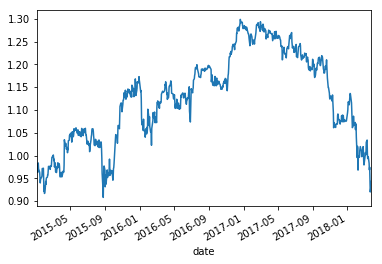

In [26]:


dailyReturns['Portfolio']= dailyReturns.dot(weights)

# Calculate cumulative returns
daily_cum_ret=(1 + dailyReturns).cumprod()

daily_cum_ret.Portfolio.plot()

### Annualized Returns

In [64]:
sp500_value = pd.read_csv('data/sp500.csv', parse_dates=['date'], index_col='date')
print(sp500_value.head(2))
print(sp500_value.tail(2))

                 S&P500
date                   
2015-01-02  2058.199951
2015-01-05  2020.579956
                 S&P500
date                   
2019-03-18  2832.939941
2019-03-19  2832.570068


In [80]:
end_date = sp500_value.index.searchsorted(dt.datetime(2019, 1, 2))
sp500_4years = sp500_value.iloc[: end_date]
print(sp500_4years.tail())
print()

total_return = (sp500_4years.iloc[-1] - sp500_4years.iloc[0]) / sp500_4years.iloc[0]
# Annualize the total return spanning 4 years
n_years = 4
annualized_return = ((1 + total_return) ** (1 / n_years)) - 1
print (annualized_return)

                 S&P500
date                   
2018-12-24  2351.100098
2018-12-26  2467.699951
2018-12-27  2488.830078
2018-12-28  2485.739990
2018-12-31  2506.850098

S&P500    0.050534
dtype: float64


In [79]:
end_date = sp500_value.index.searchsorted(dt.datetime(2018, 6, 1))
sp500_months = sp500_value.iloc[: end_date]
print(sp500_months.tail())
print()

def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

start_date = sp500_months.index[0]
end_date = sp500_months.index[-1]
n_months = diff_month(sp500_months.index[-1], sp500_months.index[0])
print(n_months)
print()

total_return = (sp500_months.iloc[-1] - sp500_months.iloc[0]) / sp500_months.iloc[0]
# Annualize the total return.
annualized_return = ((1 + total_return) ** (12 / n_months)) - 1
print (annualized_return)

                 S&P500
date                   
2018-05-24  2727.760010
2018-05-25  2721.330078
2018-05-29  2689.860107
2018-05-30  2724.010010
2018-05-31  2705.270020

40

S&P500    0.085468
dtype: float64


You can use the formula below to estimate the average annual return of a stock given the average daily return and the number of trading days (252) in a year:
To get annual average return, do NOT simply multiple daily avg. return with no. of trading days in a year.

<img src='images/scale_avg_return.png' width=500 />

## Risk (std. dev. and variance)

In [27]:
stockPrice = pd.read_csv('data/small_portfolio.csv', parse_dates=['date'], index_col='date')

daily_returns = stockPrice.pct_change()
weights = np.array([0.05, 0.4, 0.3, 0.25])

# Calculate the covariance matrix - annual
cov_matrix = (daily_returns.cov()) * 250

# Calculate the portfolio variance
port_variance = np.dot(weights.T, np.dot(cov_matrix, weights))

print(str(np.round(port_variance, 4) * 100) + '%')

2.55%


In [28]:
# Calculate the standard deviation 
port_standard_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

print(str(np.round(port_standard_dev, 4) * 100) + '%')

15.959999999999999%


In the above examples, daily returns of individual stocks that constitute the portfolio are used to calculate the risk (std. dev. or variace) of the portfolio. Alternatively, first the daily returns of the portfolio can be calculated and the std. dev. or variance of daily returns of the portfolio is the portfolio's risk. If daily retuns of portfolio is calculated, covarinace matrix need not be calculated from daily returns of constituents of portfolio.

## Risk adjusted returns (Sharpe Ratio)

In [ ]:
sp500_value = pd.read_csv('data/sp500.csv', parse_dates=['date'], index_col='date')
print(sp500_value.head(2))
print(sp500_value.tail(2))

end_date = sp500_value.index.searchsorted(dt.datetime(2019, 1, 2))
sp500_4years = sp500_value.iloc[: end_date]

In [84]:
rfr = 0  # Risk free rate

# Calculate total return and annualized return from price data 
total_return = (sp500_4years.iloc[-1] - sp500_4years.iloc[0]) / sp500_4years.iloc[0]

# Annualize the total return over 4 year 
annualized_return = ((1 + total_return) ** (1 / 4)) - 1

# Calculate daily returns 
returns_sp500 = sp500_4years.pct_change()

# Calculate annualized volatility from the standard deviation
annul_vol_sp500 = returns_sp500.std() * np.sqrt(250)

# Calculate the Sharpe ratio 
sharpe_ratio = ((annualized_return - rfr) / annul_vol_sp500)
print (sharpe_ratio)

S&P500    0.371294
dtype: float64


Portfolio's Sharpe Ratio can be calculated in a similar way.

## Skewness and Kurtosis

<img src='images/skewness.png' width=500 />
<img src='images/kurtosis.png' width=500 />

In [86]:
sp500_value = pd.read_csv('data/sp500.csv', parse_dates=['date'], index_col='date')
returns_sp500 = sp500_value.pct_change()

# Print the mean
print("mean : ", returns_sp500.mean()*100)

# Print the standard deviation
print("Std. dev  : ", returns_sp500.std()*100)

# Print the skewness
print("skew : ", returns_sp500.skew())

# Print the kurtosis
print("kurt : ", returns_sp500.kurtosis())

mean :  S&P500    0.0339
dtype: float64
Std. dev  :  S&P500    0.861002
dtype: float64
skew :  S&P500   -0.383199
dtype: float64
kurt :  S&P500    3.922391
dtype: float64


skew :  GE      0.177313
JPM     0.018815
MSFT    0.515431
PG     -0.259934
dtype: float64
kurt :  GE      7.766370
JPM     3.831448
MSFT    9.882177
PG      2.848092
dtype: float64


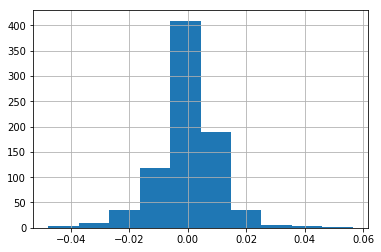

skew :  -0.15947595247438018
kurt :  3.5472000539133446


In [88]:
stockPrice = pd.read_csv('data/small_portfolio.csv', parse_dates=['date'], index_col='date')
stock_returns = stockPrice.pct_change()
weights = np.array([0.5, 0.2, 0.2, 0.1])
pf_returns = stock_returns.dot(weights)

# Print skewness and kurtosis of the stocks
print ("skew : ", stock_returns.skew())
print ("kurt : ", stock_returns.kurtosis())

# Print the histogram of the portfolio
pf_returns.hist()
plt.show()

# Print skewness and kurtosis of the portfolio
print ("skew : ", pf_returns.skew())
print ("kurt : ", pf_returns.kurtosis())

## Sortiono Ratio

<img src='images/sortino_ratio.png' width=300/>

In [ ]:
stockPrice = pd.read_csv('data/small_portfolio.csv', parse_dates=['date'], index_col='date')
stock_returns = stockPrice.pct_change()
weights = np.array([0.5, 0.2, 0.2, 0.1])
pf_returns = stock_returns.dot(weights)

In [92]:
df = pf_returns.to_frame()
df.rename(columns={0: 'pf_returns'}, inplace=True)
df.head()

,pf_returns
date,
2015-01-02,NaN
2015-01-05,-0.017723
2015-01-06,-0.019328
2015-01-07,0.003579
2015-01-08,0.017518


In [93]:
target = 0  # returns less than 0 are being for calculating sortino ratio

# Create a downside return column with the negative returns only
downside_returns = df.loc[df['pf_returns'] < target]

# Calculate expected return and std dev of downside
expected_return = df['pf_returns'].mean()
down_stdev = downside_returns['pf_returns'].std()

# Calculate the sortino ratio
sortino_ratio = (expected_return - rfr) / down_stdev

# Print the results
print("Expected return  : ", expected_return*100)
print("Downside risk   : ", down_stdev*100)
print("Sortino ratio : ", sortino_ratio)

Expected return  :  -0.0016782226618545974
Downside risk   :  0.786114437663311
Sortino ratio :  -0.0021348325147710514


In the above example we used daily average retuns and daily std. dev. (downside risk). Sortino ratio can also be calculated using annual return and annual std. dev. (downside risk) 

## Draw-down

In [110]:
df = pd.read_csv('data/sp500.csv', parse_dates=['date'], index_col='date')
roll_max = df.rolling(center=False,min_periods=1,window=252).max()

assert df.shape == roll_max.shape

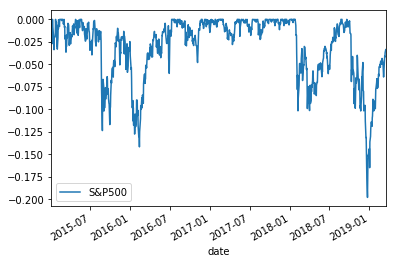

In [111]:
daily_draw_down = (df / roll_max) - 1.0
daily_draw_down.plot()

Since the price of a security will always be lower than its max-price, daily_draw_down values are all negative

In [112]:
# Calculate the minimum (most negative) daily draw-down
max_daily_draw_down = daily_draw_down.rolling(center=False, min_periods=1, window=252).min()

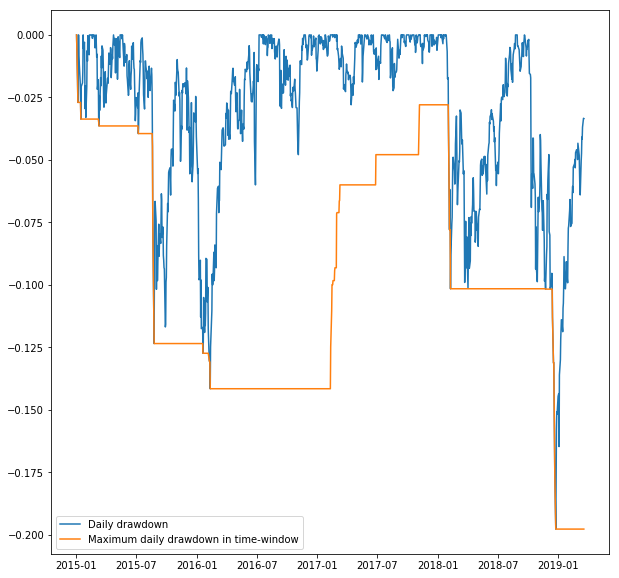

In [113]:
plt.figure(figsize=(10,10))
plt.plot(daily_draw_down.index, daily_draw_down, label='Daily drawdown')
plt.plot(max_daily_draw_down.index, max_daily_draw_down, label='Maximum daily drawdown in time-window')
plt.legend()
plt.show()

Note that the daily_draw_down and max_daily_draw_down are calculated for <u>1 year windows</u>.

**Active return** is the performance of an (active) investment, relative to the investment's
benchmark. Calculated as the difference between the benchmark and the actual return. Active return is achieved by "active" investing, i.e. taking overweight and underweight positions from the benchmark.

**Active Weights**: Weight assgned to <u>sectors</u> in a portfolio.
<img src="images/active_weights.png" width=400 />

**Tracking error** is the name used for the difference in portfolio and benchmark for a passive
investment fund.

In [9]:
portfolio_data = pd.read_csv('data/large_pf.csv')

In [10]:
portfolio_data.head()

,Unnamed: 0,mean_return,variance,pf_weights,bm_weights,Security,GICS Sector,GICS Sub Industry
0,A,0.146146,0.035194,0.000,0.0,Agilent Technologies Inc,Health Care,Health Care Equipment
1,AAL,0.444411,0.094328,0.214,0.0,American Airlines Group,Industrials,Airlines
2,AAP,0.242189,0.029633,0.000,0.0,Advance Auto Parts,Consumer Discretionary,Automotive Retail
3,AAPL,0.225074,0.027283,0.000,0.0,Apple Inc.,Information Technology,Computer Hardware
4,ABBV,0.182541,0.029926,0.000,0.0,AbbVie,Health Care,Pharmaceuticals


In [12]:
portfolio_data = portfolio_data.rename(columns={'Unnamed: 0': 'ticker'}).set_index('ticker')

In [13]:
portfolio_data.head()

,mean_return,variance,pf_weights,bm_weights,Security,GICS Sector,GICS Sub Industry
ticker,,,,,,,
A,0.146146,0.035194,0.000,0.0,Agilent Technologies Inc,Health Care,Health Care Equipment
AAL,0.444411,0.094328,0.214,0.0,American Airlines Group,Industrials,Airlines
AAP,0.242189,0.029633,0.000,0.0,Advance Auto Parts,Consumer Discretionary,Automotive Retail
AAPL,0.225074,0.027283,0.000,0.0,Apple Inc.,Information Technology,Computer Hardware
ABBV,0.182541,0.029926,0.000,0.0,AbbVie,Health Care,Pharmaceuticals


In [18]:
print(portfolio_data['pf_weights'].sum())
print(portfolio_data['bm_weights'].sum())

100.0
100.001


In [17]:
total_return_pf = (portfolio_data['pf_weights']*portfolio_data['mean_return']).sum()
total_return_bm = (portfolio_data['bm_weights'] * portfolio_data['mean_return']).sum()
active_return = total_return_pf - total_return_bm
print ("%.2f%%" % active_return)

22.58%


In [20]:
grouped_df=portfolio_data.groupby('GICS Sector').sum()

# Calculate active weights of portfolio
grouped_df['active_weight']= grouped_df['pf_weights'] - grouped_df['bm_weights']
print (grouped_df['active_weight'])

GICS Sector
Consumer Discretionary         20.257
Consumer Staples               -5.176
Energy                          0.000
Financials                     -2.116
Health Care                     2.865
Industrials                     2.465
Information Technology          8.693
Materials                      -2.043
Real Estate                     2.014
Telecommunications Services    -1.367
Utilities                     -25.593
Name: active_weight, dtype: float64


In [21]:
# Sum of active weights should be zero

grouped_df['active_weight'].sum()

-0.0010000000000047748

# Factors

In [24]:
factor_data = pd.read_csv('data/pf_factors.csv', parse_dates=['date'], index_col="date")

In [25]:
factor_data.head()

,S&P500,WML,value_factor,portfolio
date,,,,
2016-01-04,-1.530373,-1.69,-1.53,-1.651745
2016-01-05,0.201223,0.38,0.10,0.408161
2016-01-06,-1.311540,1.27,-1.22,0.325555
2016-01-07,-2.370044,0.21,-2.38,-0.698259
2016-01-08,-1.083837,-0.20,-0.91,-0.959352


In [28]:
factor_data = factor_data.rename(columns={'S&P500': 'sp500', 'WML': 'momentum', 'value_factor': 'value'})

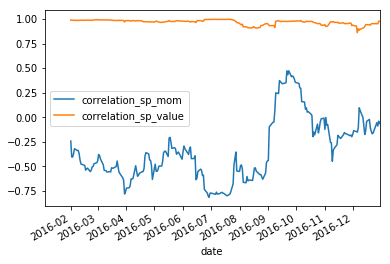

In [34]:
# Calculate 20-day rolling correlation with momentum 
factor_data['correlation_sp_mom']=factor_data['sp500'].rolling(20).corr(factor_data['momentum'])

# Calculate 20-day rolling correlation with value
factor_data['correlation_sp_value']=factor_data['sp500'].rolling(20).corr(factor_data['value'])

# Plot the correlations
factor_data['correlation_sp_mom'].plot()
factor_data['correlation_sp_value'].plot()
plt.legend()
plt.show()

If a portfolio is showing chnages in correlation to factor, what could eb the reason?

- By changing your portfolio weights based on your investment strategy, the underlying factor exposures also change.
- The underlying returns of the stocks that make up a factor returns, can fluctuate heavily, causing the factor returns to deviate from your portfolios return.
- The composition of a factor changes over time, i.e. the stocks that are deemed high "value" will change over time, and thereby the value factor returns can deviate from the portfolio returns.

In [31]:
factor_returns = pd.read_csv('data/factors_pf_returns.csv', parse_dates=['date'], index_col="date")

In [32]:
print(factor_returns.corr())

              Mkt-RF       SMB       HML        RF  pf_returns
Mkt-RF      1.000000  0.331250  0.099800  0.087073    0.738586
SMB         0.331250  1.000000 -0.108081  0.076750    0.162303
HML         0.099800 -0.108081  1.000000 -0.049019   -0.237647
RF          0.087073  0.076750 -0.049019  1.000000    0.039383
pf_returns  0.738586  0.162303 -0.237647  0.039383    1.000000


Based on the correlation matrix, we can say that the performance of this portfolio can largely be explained by market returns, but not so much by factor returns.

In [35]:
# Define the model
model = sm.OLS(factor_returns['pf_returns'], factor_returns[['Mkt-RF','SMB', 'HML']]).fit()

# Create model predictions
predictions = model.predict(factor_returns[['Mkt-RF','SMB', 'HML']]) 

# Print out the summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             pf_returns   R-squared (uncentered):                   0.657
Model:                            OLS   Adj. R-squared (uncentered):              0.653
Method:                 Least Squares   F-statistic:                              158.8
Date:                Tue, 17 Mar 2020   Prob (F-statistic):                    1.55e-57
Time:                        20:52:12   Log-Likelihood:                         -185.67
No. Observations:                 252   AIC:                                      377.3
Df Residuals:                     249   BIC:                                      387.9
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.8234      0.040     20.627      0.000       0.745       0.902
SMB           -0.2272      0.064     -3.545      0.000      -0.353      -0.101
HML           -0.4826      0.056     -8.611      0.000      -0.593      -0.372
==============================================================================
Omnibus:                      143.224   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1746.552
Skew:                           1.972   Prob(JB):                         0.00
Kurtosis:                      15.279   Cond. No.                         1.89
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
model.params

Mkt-RF    0.823443
SMB      -0.227198
HML      -0.482598
dtype: float64

# pyfolio

In [45]:
price_df = pd.read_csv('data/sp500.csv', parse_dates=['date'], index_col='date')
print(price_df.head())

returns_df = price_df.pct_change()
returns_df.head()

                 S&P500
date                   
2015-01-02  2058.199951
2015-01-05  2020.579956
2015-01-06  2002.609985
2015-01-07  2025.900024
2015-01-08  2062.139893


,S&P500
date,
2015-01-02,NaN
2015-01-05,-0.018278
2015-01-06,-0.008893
2015-01-07,0.011630
2015-01-08,0.017888


Start date,2015-01-02
End date,2019-03-19
Total months,50
,Backtest
Annual return,7.9%
Cumulative returns,37.6%
Annual volatility,13.7%
Sharpe ratio,0.63
Calmar ratio,0.40
Stability,0.85
Max drawdown,-19.8%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,19.78,2018-09-20,2018-12-24,NaT,NaN
1,14.16,2015-05-21,2016-02-11,2016-07-11,298
2,10.16,2018-01-26,2018-02-08,2018-08-24,151
3,4.79,2016-08-15,2016-11-04,2016-11-21,71
4,3.64,2015-03-02,2015-03-11,2015-04-24,40


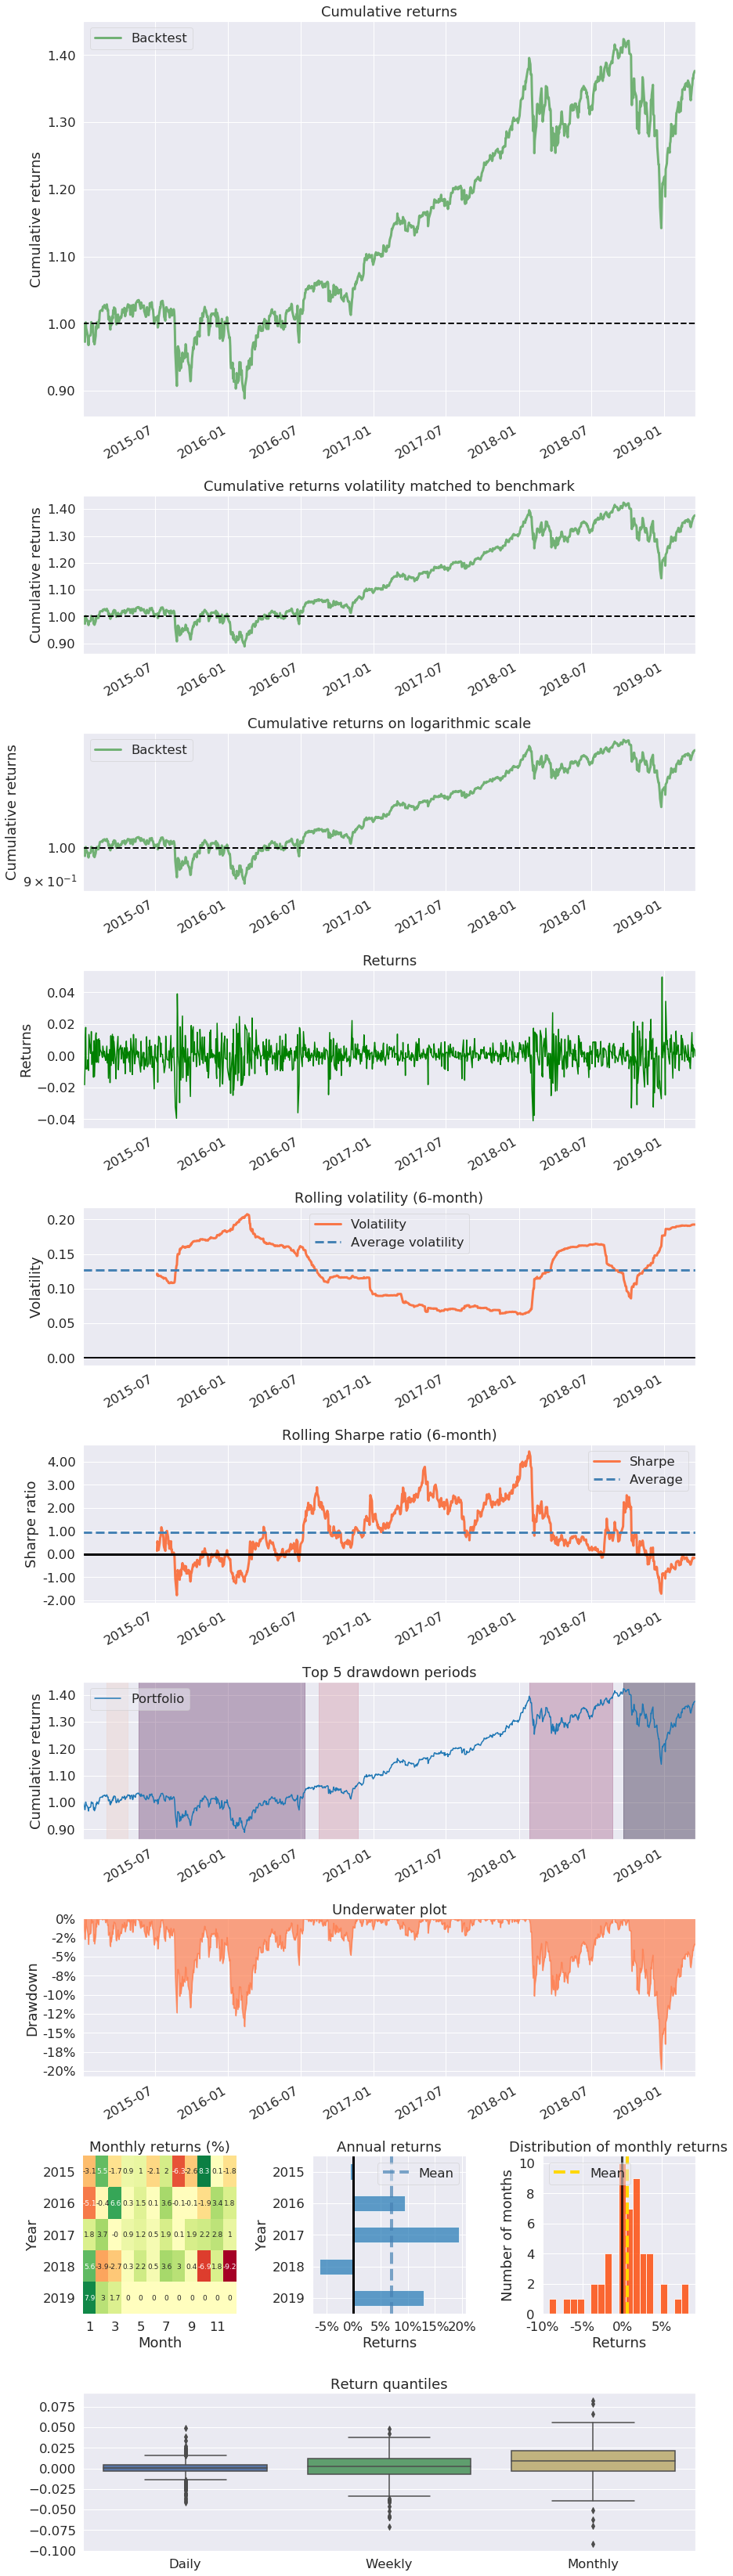

In [46]:
# Index needs to be of dtype datetime.
# Returns should be a pandas Series.

returns=returns_df['S&P500']  # returns is a Series

# Create the returns tear sheet
pf.create_returns_tear_sheet(returns)


pyfolio also has a **`create_positions_tear_sheet()`**

# Portfolio Optimization

<img src="images/optimization_problem.png" width=350 />
<img src="images/efficient_frontier.png" width=350 />

In [2]:
stock_prices = pd.read_csv('data/small_portfolio.csv', parse_dates=['date'], index_col='date')
stock_prices.head()

,GE,JPM,MSFT,PG
date,,,,
2015-01-02,25.06,62.49,46.760,90.44
2015-01-05,24.60,60.55,46.325,90.01
2015-01-06,24.07,58.98,45.650,89.60
2015-01-07,24.08,59.07,46.230,90.07
2015-01-08,24.37,60.39,47.590,91.10


In [9]:
stock_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 813 entries, 2015-01-02 to 2018-03-27
Data columns (total 4 columns):
GE      813 non-null float64
JPM     813 non-null float64
MSFT    813 non-null float64
PG      813 non-null float64
dtypes: float64(4)
memory usage: 31.8 KB


In [3]:
# Calculate expected annualized returns and sample covariance
mu = expected_returns.mean_historical_return(stock_prices)
sigma = risk_models.sample_cov(stock_prices)

In [4]:
mu

GE     -0.170134
JPM     0.193822
MSFT    0.228539
PG     -0.036344
dtype: float64

In [5]:
sigma

,GE,JPM,MSFT,PG
GE,0.046355,0.023011,0.016415,0.010182
JPM,0.023011,0.047033,0.024328,0.010899
MSFT,0.016415,0.024328,0.054486,0.014257
PG,0.010182,0.010899,0.014257,0.020810


In [15]:
ef = EfficientFrontier(mu, sigma)

In [20]:
# Max Sharpe portfolio

max_sharpe_weights = ef.max_sharpe()
print(max_sharpe_weights)
print()
print(ef.clean_weights())  # clean weights of max sharpe portfolio
print()
ef.portfolio_performance(verbose=True)

{'GE': 2.6425725226027334e-16, 'JPM': 0.44136825393249157, 'MSFT': 0.5586317460675082, 'PG': 0.0}

{'GE': 0.0, 'JPM': 0.44137, 'MSFT': 0.55863, 'PG': 0.0}

Expected annual return: 21.3%
Annual volatility: 19.5%
Sharpe Ratio: 0.99


(0.21321613110705756, 0.19535212180581962, 0.989065945744448)

In [21]:
# Min Volatility portfolio

min_volatility_weights = ef.min_volatility()
print(min_volatility_weights)
print()
print(ef.clean_weights())  # clean weights of max sharpe portfolio
print()
ef.portfolio_performance(verbose=True)

{'GE': 0.15825279953093277, 'JPM': 0.11004268623078652, 'MSFT': 0.05305069577900048, 'PG': 0.6786538184592803}

{'GE': 0.15825, 'JPM': 0.11004, 'MSFT': 0.05305, 'PG': 0.67865}

Expected annual return: -1.8%
Annual volatility: 13.3%
Sharpe Ratio: -0.29


(-0.018136398037901267, 0.13293210142256562, -0.28688629480604527)

In [10]:
# Get the minimum risk portfolio for a target return 
weights = ef.efficient_return(0.2)
print (weights)

print()
# Show portfolio performance 
print(ef.portfolio_performance(verbose=True))

{'GE': 0.0, 'JPM': 0.48580107845142173, 'MSFT': 0.47012823827434375, 'PG': 0.044070683274234516}

Expected annual return: 20.0%
Annual volatility: 18.8%
Sharpe Ratio: 0.96
(0.19999999993941342, 0.18802343260113766, 0.9573274854589816)


In [23]:
# Define exponentially weighted Sigma and mu using stock_prices
Sigma = risk_models.exp_cov(stock_prices, span=180, frequency=252)
mu = expected_returns.ema_historical_return(stock_prices, frequency=252, span=180)


# The parameter frequency=252 gives annual mu and annual sigma

ef = EfficientFrontier(mu, Sigma)
raw_weights_maxsharpe = ef.max_sharpe()

ef.portfolio_performance(verbose=True)

print()
print(raw_weights_maxsharpe)

Expected annual return: 23.4%
Annual volatility: 23.8%
Sharpe Ratio: 0.90

{'GE': 0.0, 'JPM': 0.1882820469180203, 'MSFT': 0.8117179530819809, 'PG': 2.726211301374236e-15}


What could be a reason why the two portfolios (eqponential weighted mu, sigma and equal weighted mu, sigma) are actually not that different to each other?
- The span of 252 is pretty long relative the the full dataset, which means both are calculated with largely the same data input.
- The trends in the data are relatively persistent: that's why weights for example GE and PG are zero for both portfolios, and both portfolios only invest in JPM and MSFT.

### Effect of changing span

In [26]:
# Calculate expected returns and sample covariance
mu_ema = expected_returns.ema_historical_return(stock_prices, span=504 ,frequency=252)
Sigma_ew = risk_models.exp_cov(stock_prices, span=504, frequency=252)
ef_2 = EfficientFrontier(mu_ema, Sigma_ew)

# Calculate weights for the maximum Sharpe ratio portfolio
weights = ef_2.max_sharpe()
cleaned_weights_maxsharpe_EW = ef_2.clean_weights()
perf_max_sharpe_EW = ef_2.portfolio_performance(verbose=True)

print()
print(cleaned_weights_maxsharpe_EW)

Expected annual return: 26.4%
Annual volatility: 18.5%
Sharpe Ratio: 1.32

{'GE': 0.0, 'JPM': 0.44882, 'MSFT': 0.55118, 'PG': 0.0}


In [27]:
# Calculate expected returns and sample covariance
mu_ema = expected_returns.ema_historical_return(stock_prices, span=10 ,frequency=252)
Sigma_ew = risk_models.exp_cov(stock_prices, span=10, frequency=252)
ef_2 = EfficientFrontier(mu_ema, Sigma_ew)

# Calculate weights for the maximum Sharpe ratio portfolio
weights = ef_2.max_sharpe()
cleaned_weights_maxsharpe_EW = ef_2.clean_weights()
perf_max_sharpe_EW = ef_2.portfolio_performance(verbose=True)

print()
print(cleaned_weights_maxsharpe_EW)

Expected annual return: 12.1%
Annual volatility: 17.0%
Sharpe Ratio: 0.59

{'GE': 0.0, 'JPM': 0.0, 'MSFT': 0.0, 'PG': 1.0}


If your data is very volatile and changes rapidly, working with a short span might give you better predictive power of the expected return, with a faster moving investment strategy. However, if your data is rather slow moving as is the case with this data, the short span does not help you in better predicting expected risk and returns.